# Classification des probabilités de défaut 

# 1. Préparation des données

In [89]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randn
import tensorflow as tf

from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Conv2D
from tensorflow.keras.optimizers import SGD,Adam,Nadam,Adadelta
from tensorflow import keras

from sklearn import preprocessing, model_selection
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## a. Chargement du dataset

In [90]:
df = pd.read_csv('market_data_pd.csv',sep=',')
df.shape

(48836, 24)

In [91]:
df.sort_values('Error %', ascending=False, inplace=True)
df.head(5000)

,Unnamed: 0,Reference Security,Bid Price,Ask Price,Mid Price,Cpn,Maturity,Common Eqty / Tot Assets,Debt / Common Equity,TCE Ratio,...,Amt Out,Total Assets,BCLASS Level 3,Guarantee Type,Guarantor Type,Collat Type,PD_1y,reprice,maturity_years,Error %
5909,5909,ZS424035 Corp,0.010,0.750,0.3800,1.5000,04/26/2024,-147.17300,NaN,-149.82800,...,1.186770e+09,3359.72,Other Industrial,Multiple,Subsidiaries,SR SECURED,1.000000,40.007513,2.709589,1.042829e+04
1456,1456,AN346569 Corp,0.125,0.700,0.4125,3.8750,10/25/2022,12.72580,177.3660,-23.21850,...,4.000000e+08,1808.09,Electric,Multiple,Parent & Subsidiaries,SR SECURED,1.000000,40.007513,1.205479,9.598791e+03
827,827,AL458635 Corp,0.250,1.750,1.0000,6.2500,06/15/2022,NaN,NaN,NaN,...,7.500000e+08,NaN,Consumer Cyclical,N.A.,N.A.,SR UNSECURED,1.000000,42.507983,0.843836,4.150798e+03
44900,44900,QJ879163 Corp,0.407,1.481,0.9440,9.8776,12/01/2025,5.74708,467.7130,4.97044,...,2.000000e+08,1002610.00,Banking,N.A.,N.A.,SUBORDINATED,1.000000,40.007513,4.309589,4.138084e+03
44899,44899,QJ879163 Corp,0.396,1.499,0.9475,9.8776,12/01/2025,5.74708,467.7130,4.97044,...,2.000000e+08,1002610.00,Banking,N.A.,N.A.,SUBORDINATED,1.000000,40.007513,4.309589,4.122429e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20292,20292,BM704638 Corp,103.425,103.699,103.5620,1.6250,05/30/2027,50.57070,80.3467,50.53560,...,3.000000e+08,6451.85,REITs,N.A.,N.A.,SR UNSECURED,0.021957,103.562000,5.802740,1.520241e-09
20302,20302,BM704638 Corp,103.423,103.697,103.5600,1.6250,05/30/2027,50.57070,80.3467,50.53560,...,3.000000e+08,6451.85,REITs,N.A.,N.A.,SR UNSECURED,0.021962,103.560000,5.802740,1.520216e-09
20300,20300,BM704638 Corp,103.424,103.697,103.5605,1.6250,05/30/2027,50.57070,80.3467,50.53560,...,3.000000e+08,6451.85,REITs,N.A.,N.A.,SR UNSECURED,0.021961,103.560500,5.802740,1.520208e-09
20291,20291,BM704638 Corp,103.416,103.689,103.5525,1.6250,05/30/2027,50.57070,80.3467,50.53560,...,3.000000e+08,6451.85,REITs,N.A.,N.A.,SR UNSECURED,0.021983,103.552500,5.802740,1.520024e-09


In [92]:
def count_nan(df):
    for col_name in df.columns:
        n_nan = df[col_name].isna().sum()
        if n_nan > 0:
            print("Colomn : ", col_name)  
            print("NaN : {}/{}".format(n_nan,len(df[col_name])))
            print("===============================================")
            
#count_nan(df)

In [93]:
df = df[df.PD_1y>0.0]
df = df[df.PD_1y!=1.0]

df.columns

Index(['Unnamed: 0', 'Reference Security', 'Bid Price', 'Ask Price',
       'Mid Price', 'Cpn', 'Maturity', 'Common Eqty / Tot Assets',
       'Debt / Common Equity', 'TCE Ratio', 'Tot Debt / Tot Capital',
       'Tot Cap (Local Crncy)', 'Is Covered', 'Is Convertible', 'Amt Out',
       'Total Assets', 'BCLASS Level 3', 'Guarantee Type', 'Guarantor Type',
       'Collat Type', 'PD_1y', 'reprice', 'maturity_years', 'Error %'],
      dtype='object')

In [94]:
np.median(df['Error %'])

1.3649059429100234e-14

In [95]:
df1 = df[['Common Eqty / Tot Assets','TCE Ratio','Tot Debt / Tot Capital','Tot Cap (Local Crncy)','Is Covered','Is Convertible','Amt Out','BCLASS Level 3', 'Guarantee Type','Total Assets', 'Guarantor Type', 'Collat Type','Debt / Common Equity','PD_1y']]
df1 = df1[df1['Debt / Common Equity']<2500]
df1 = df1[df1['TCE Ratio']>-100]
#df1.replace(np.nan, 0.0,inplace=True)
df1.dropna(inplace=True)

In [96]:
df1 = df1.drop_duplicates()
df1.shape

(36107, 14)

## b. Traitement des données

Nous commencerons par séparer les données non étiquietées des étiquettes, les étiquettes se trouvent dans l'array `y_full` et le reste des données dans `X_full`

In [97]:
X_full = np.array(df1.drop(columns=['PD_1y']))
y_full = np.array(df1['PD_1y'])

La prochaine étape consiste à séparer les features continues des features discrètes, cela sera utile car leurs traitements seront différent

In [98]:
features = list(df1.drop(columns=['PD_1y']).columns)

discrete_features = ['BCLASS Level 3','Guarantee Type','Guarantor Type','Collat Type','Is Covered','Is Convertible']
continuous_features = [s for s in features if not s in discrete_features]


continuous_features_idx = [features.index(feat_name) for feat_name in continuous_features]
discrete_features_idx = [features.index(feat_name) for feat_name in discrete_features]

In [99]:
## A FAIRE COMME CELA :
"""
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X_train_submit)

X_train_submit = enc.transform(X_train_submit)
X_test_submit = enc.transform(X_test_submit)

"""



class Pipeline:
    def __init__(self, X_train, X_full = None):
        """
        Se fit sur le jeu de TRAIN, une seule fois
        """
        self.ohe = preprocessing.OneHotEncoder(categories='auto',sparse=False).fit(X_full[:,discrete_features_idx])
        self.std_scaler = preprocessing.StandardScaler().fit(X_train[:,continuous_features_idx])
        print(self.ohe.categories_)
        
    def traitement(self,X):
        """
        Permet de traiter n'importe quel vecteur X ensuite
        """
    
        X_continuous_scaled = self.std_scaler.transform(X[:,continuous_features_idx])
        X_discrete_encoded = self.ohe.transform(X[:,discrete_features_idx])
        print('moyenne = {}'.format(np.mean(X_continuous_scaled)))
        
        X_processed = np.hstack((X_discrete_encoded, X_continuous_scaled))
    
        return X_processed

In [100]:
X_train, X_test_, y_train, y_test = model_selection.train_test_split(X_full, y_full, test_size=0.1,
                                                                    #stratify=y_full, # stratification
                                                                    random_state=92)

pipe = Pipeline(X_train,X_full)
X_train = pipe.traitement(X_train)
X_test  = pipe.traitement(X_test_)

[array(['Banking', 'Basic Industry', 'Brokerage Assetmanagers Exchanges',
       'Capital Goods', 'Communications', 'Consumer Cyclical',
       'Consumer Non-Cyclical', 'Electric', 'Energy', 'Finance Companies',
       'Government Guaranteed', 'Government Owned. No Guarantee',
       'Government Sponsored', 'Hybrid', 'Insurance', 'Local Authority',
       'Mortgage Assets', 'Natural Gas', 'Other Financial',
       'Other Industrial', 'Other Utility', 'Public Sector Loans',
       'REITs', 'Supranational', 'Technology', 'Transportation',
       'Whole Business'], dtype=object), array(['Cross Guarantee', 'Multiple', 'N.A.', 'Single'], dtype=object), array(['Bank', 'Company', 'Domestic Restricted Subsidiar',
       'Local Government', 'N.A.', 'National/Sovereign Government',
       'Other Subsidiary of Parent', 'Parent', 'Parent & Subsidiaries',
       'Subsidiaries'], dtype=object), array(['BONDS', 'COMPANY GUARNT', 'COVERED', 'GOVT GUARANTEED',
       'GOVT LIQUID GTD', 'INSURED', 'JR S

# 2. Création de classes de probabilités de défaut 

## a. Transformation des données

Text(0.5, 1.0, 'Distribution des probabilités de défaut')

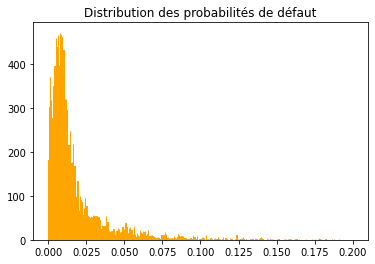

In [101]:
plt.hist(y_train, range = (0, 0.2), bins = 1000, edgecolor='orange')
plt.title('Distribution des probabilités de défaut')

*Observation :* la distribution n'est pas du tout uniforme, ressemble à une loi exponentielle. Si l'on fait le clustering (K-means) sur ces données brutes, la classe 0 et 1 vont être surchargées et les dernières classes vides. Cela sera par la suite problématique pour les algos. Nous allons donc faire une transformation par la fonction de répartition de la loi exponentielle afin d'obtenir des données mieux séparées entre elles.  

In [102]:
lam = 1/y_train.mean()

In [103]:
def loi_expo(x,lam) : 
    return lam * np.exp(- lam * x)

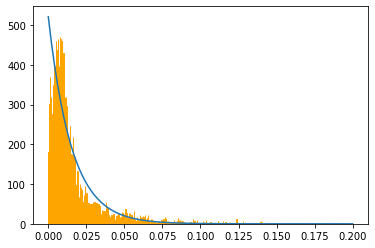

In [64]:
from pylab import *
x_arg = linspace(0, 0.2, 100)
y_arg = loi_expo(x_arg,lam) * 8

plot(x_arg, y_arg)
plt.hist(y_train, range = (0, 0.2), bins = 1000, edgecolor='orange')
show()

La distribution fit assez bien avec une loi exponentielle de paramètre lam. Nous retenons ce modèle.

In [65]:
def distrib_function(x,lam) : 
    return 1 - np.exp(- lam * x)

y_train_exp = distrib_function(y_train,lam)
y_test_exp = distrib_function(y_test,lam)

Text(0.5, 1.0, 'Distribution des probabilités de défaut après transformation')

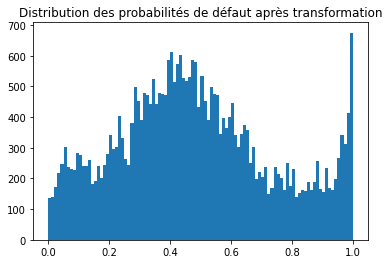

In [66]:
plt.hist(y_train_exp, range = (0, 1), bins = 100)
plt.title('Distribution des probabilités de défaut après transformation')

## b. Détermination du nombre de clusters optimal

In [67]:
from sklearn.cluster import KMeans

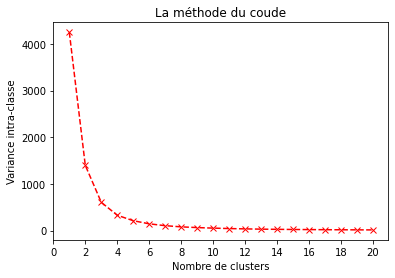

In [68]:
def regle_du_coude(base_input, nb_cluster_teste):
    
    distortions = []
    df = pd.DataFrame(columns = ['X', 'Y']) 
    df["X"]=base_input
    df["Y"]=base_input

    for k in range(1,nb_cluster_teste+1):
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel.fit(df)
        distortions.append(kmeanModel.inertia_)
    
    plt.plot(range(1,nb_cluster_teste+1), distortions, 'rx--')
    plt.xticks(range(0,nb_cluster_teste+1,2))
    plt.xlabel('Nombre de clusters',)
    plt.ylabel('Variance intra-classe')
    plt.title('La méthode du coude')
    plt.show()
    
regle_du_coude(y_train_exp,20)

Choix du nombre de clusters : 

## c. Clustering

In [69]:
class Discretizer:
    def __init__(self, y_train, nb_class=6):
        
        self.nb_class = nb_class
        self.y_train = y_train.reshape((-1,1))

        self.kbins = KBinsDiscretizer(n_bins=self.nb_class, encode='ordinal', strategy='kmeans')#strategy : uniform, quantile, kmeans
        self.kbins.fit(self.y_train)
        
        
    def discretize(self,y):
        y = y.reshape((-1,1))
        y_class = self.kbins.transform(y)
        return y_class

In [70]:
nb_class = 12
discretizer = Discretizer(y_train_exp, nb_class=nb_class)

y_train_class = discretizer.discretize(y_train_exp)
y_test_class  = discretizer.discretize(y_test_exp)

In [71]:
class classe_vers_probas:
    def __init__(self, discretizer, nb_class):
        
        self.switches = list()
        for k in range(0,nb_class): #Dichotomie
            a=0
            b=1
            mid=(b+a)/2
            while b-a > 1e-10:
                value = float(discretizer.discretize(np.array([mid])).squeeze())

                if value>k:
                    b=mid
                else:
                    a=mid
                mid=(b+a)/2
            self.switches.append(mid)

        self.switches = np.array(self.switches)
        self.means = (self.switches + np.array([0]+list(self.switches)[:-1]))/2
        
    def set_lambda(self,lam):
        self.lam = lam
        
    def inv_distrib(self, y):
        return - np.log(1 - y) / self.lam
        
    def get_proba(self, k): #k est une classe

        value_before_transfo = self.means[int(k)]
        
        return self.inv_distrib(value_before_transfo)

In [72]:

retour_proba = classe_vers_probas(discretizer,nb_class)
retour_proba.set_lambda(lam=lam)

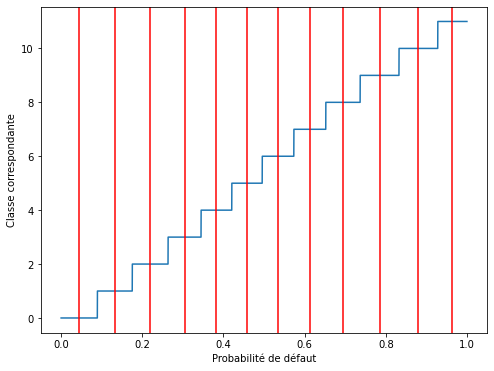

In [74]:
x_ = np.linspace(0,1,10000)
plt.figure(figsize=(8,6))
plt.plot(x_,discretizer.discretize(x_))
for xc in retour_proba.switches:
    continue
    plt.axvline(x=xc, color='red')

for xc in retour_proba.means:
    
    plt.axvline(x=xc, color='red')
    
plt.xlabel("Probabilité de défaut")
plt.ylabel("Classe correspondante")
plt.savefig('escalier.png')
plt.show()

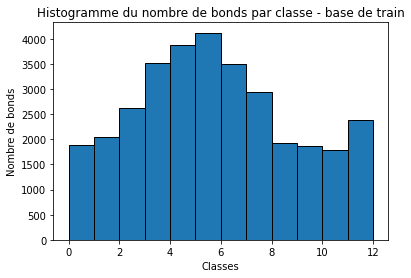

In [39]:
plt.hist(y_train_class, range = (0, nb_class), bins = nb_class, edgecolor='black' )
plt.xlabel('Classes')
plt.ylabel('Nombre de bonds')
plt.title('Histogramme du nombre de bonds par classe - base de train')
plt.show()

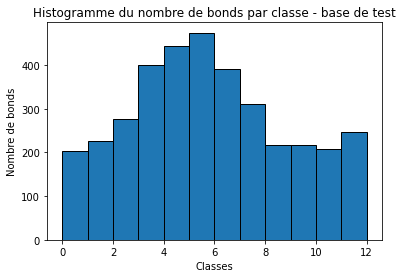

In [40]:
plt.hist(y_test_class, range = (0, nb_class), bins = nb_class, edgecolor='black' )
plt.xlabel('Classes')
plt.ylabel('Nombre de bonds')
plt.title('Histogramme du nombre de bonds par classe - base de test')
plt.show()

*Comparaison avec ce que l'on aurait eu sans transformation :*

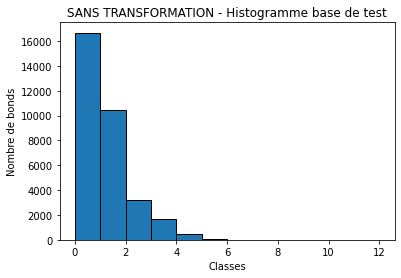

In [41]:
plt.hist(Discretizer(y_train, nb_class=nb_class).discretize(y_train), range = (0, nb_class), bins = nb_class, edgecolor='black' )
plt.xlabel('Classes')
plt.ylabel('Nombre de bonds')
plt.title('SANS TRANSFORMATION - Histogramme base de test')
plt.show()

Nous voyons bien que la transformaiton était nécessaire pour réaliser un clustering probant par la méthode des K-means. 

# III. Modèles de classification

## a. Réseau de neurones

## Entrainement du modèle

In [321]:
model = Sequential()
#model.add(Conv1D(12, 2, activation='relu',input_shape=input_shape[1:]))
model.add(Dense(units=1000,input_dim=68)) #6 is good
model.add(Dense(units=1000))
model.add(Dropout(0.4))
model.add(Dense(units=nb_class,activation="softmax")) #output

In [322]:
from tensorflow import keras 

model.compile(optimizer=keras.optimizers.Adam(lr=0.00003),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), # default from_logits=False
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

In [323]:
history = model.fit(X_train, y_train_class,         # Train the model using the training set...
          batch_size=20, epochs=50,
          verbose=1, validation_split=0.1,steps_per_epoch=250)  

Epoch 1/50
250/250 [==============================] - 1s 4ms/step - loss: 2.3286 - sparse_categorical_accuracy: 0.1754 - val_loss: 2.2426 - val_sparse_categorical_accuracy: 0.1926
Epoch 2/50
250/250 [==============================] - 1s 3ms/step - loss: 2.2295 - sparse_categorical_accuracy: 0.2036 - val_loss: 2.1747 - val_sparse_categorical_accuracy: 0.2218
Epoch 3/50
250/250 [==============================] - 1s 3ms/step - loss: 2.2023 - sparse_categorical_accuracy: 0.2176 - val_loss: 2.1420 - val_sparse_categorical_accuracy: 0.2289
Epoch 4/50
250/250 [==============================] - 1s 3ms/step - loss: 2.1504 - sparse_categorical_accuracy: 0.2330 - val_loss: 2.1240 - val_sparse_categorical_accuracy: 0.2308
Epoch 5/50
250/250 [==============================] - 1s 3ms/step - loss: 2.1285 - sparse_categorical_accuracy: 0.2310 - val_loss: 2.1026 - val_sparse_categorical_accuracy: 0.2345
Epoch 6/50
250/250 [==============================] - 1s 3ms/step - loss: 2.1123 - sparse_categorica

113/113 [==============================] - 0s 1ms/step - loss: 2.0329 - sparse_categorical_accuracy: 0.2517
The final loss on the TEST set is: 2.03.
The final sparse_categorical_accuracy on the TEST set is: 0.25.


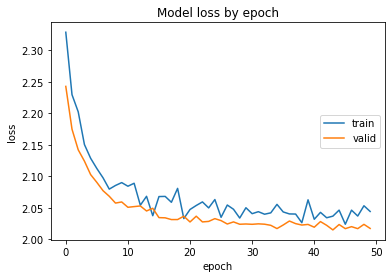

In [324]:
# --------------------------------------
# Evaluation
# --------------------------------------
for loss_name, loss_value in list(zip(model.metrics_names, model.evaluate(X_test, y_test_class, verbose=1))):
    print('The final {} on the TEST set is: {:.2f}.'.format(loss_name, loss_value)) # Evaluate the trained model on the test set!

# --------------------------------------
# Loss functions evolution
# --------------------------------------
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.show()

## Observation des résultats


*Fonctions à charger*

In [42]:
from sklearn.metrics import plot_confusion_matrix

def ViewClassResult(model,continuous=False):
    if continuous:
        y=model.predict(np.squeeze(X_test))
        y_predicted = [np.argmax(pred) for pred in y]
    else:
        y_predicted=model.predict(np.squeeze(X_test))
    
    print(np.sum(y_predicted==y_test_class[:,0]),'/',len(y_predicted))
    CM = confusion_matrix(y_test_class[:,0], y_predicted)
    
    
    fig, ax = plt.subplots(figsize=(10, 10))
    #plot_confusion_matrix(model, X_test, y_test_class, ax=ax)
    
    
    ConfusionMatrixDisplay(CM).plot(ax=ax)
    
    
    #Si il y a trop de classes:
    """
        plt.figure(figsize=(80, 60))
    plt.matshow(CM)
    plt.colorbar()
    plt.ylabel('True Label')
    plt.xlabel('Predicated Label')
    
    """

    
    plt.savefig('CM_RF.png')

    
    
    
def ShowFeatureImportances(model):
    """
    Shows the feature importances for a given model
    """
    importance = model.feature_importances_
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))

    plt.bar([x for x in range(len(importance))], importance)
    plt.show()

In [43]:
909 / 3611

0.25173082248684575

*Résultats du réseau de neurones*

909 / 3611


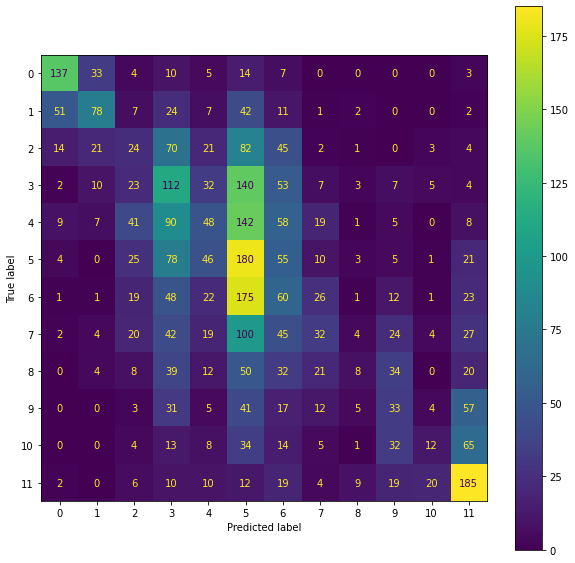

In [354]:
ViewClassResult(model,continuous=True)

## b. One VS Rest 

In [104]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import SVC

#poly & degree=11

OvR_clf = OneVsOneClassifier(SVC(kernel='rbf'),n_jobs=-1).fit(X_train, y_train_class)


print(OvR_clf.score(X_test,y_test_class))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


0.37053447798393796


1338 / 3611


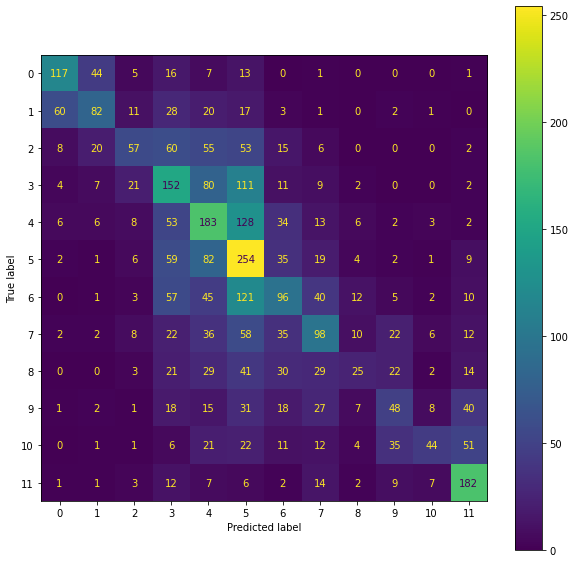

In [105]:
ViewClassResult(OvR_clf)

## c. Random Forest

In [47]:
from sklearn.ensemble import RandomForestClassifier

rf2_clf = RandomForestClassifier(n_estimators=100,
                                     criterion='gini', #{“gini”, “entropy”}
                                     max_depth=100,#10,#0, #default=None
                                     min_samples_split=3, #int or float, default=2
                                     random_state=42,
                                     max_features='auto',
                                     bootstrap=True,
                                     min_samples_leaf=1
                                    )

rf2_clf.fit(X_train, np.ravel(y_train_class))



print(rf2_clf.score(X_test,y_test_class))
"""
{'estimator__n_estimators': 800, 
 'estimator__min_samples_split': 2, 
 'estimator__min_samples_leaf': 1, 
 'estimator__max_features': 'auto', 
 'estimator__max_depth': 100, 
 'estimator__bootstrap': True}
"""

0.7191913597341457


"\n{'estimator__n_estimators': 800, \n 'estimator__min_samples_split': 2, \n 'estimator__min_samples_leaf': 1, \n 'estimator__max_features': 'auto', \n 'estimator__max_depth': 100, \n 'estimator__bootstrap': True}\n"

In [338]:
N[list(scores).index(max(scores))]

100

In [339]:
#plt.plot(n,Y__)
#plt.savefig('variation_arbres_rf.png')

In [340]:
#print(n[list(Y__).index(max(Y__))])

2628 / 3611


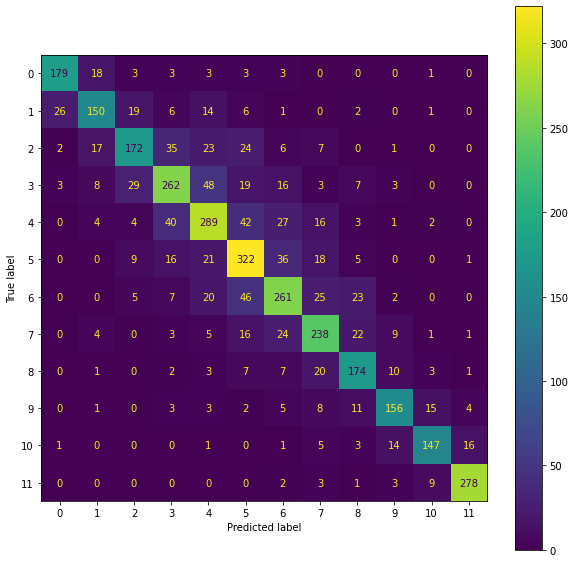

In [358]:
ViewClassResult(rf2_clf)

In [342]:
rf2_clf.predict(X_test)

array([10.,  7.,  5., ..., 10.,  1., 10.])

In [343]:
#repasser sur du continue après les classes.
#>6 classes 

array([0.0329399 , 0.01321884, 0.0099451 , ..., 0.03710386, 0.00202061,
       0.02768671])

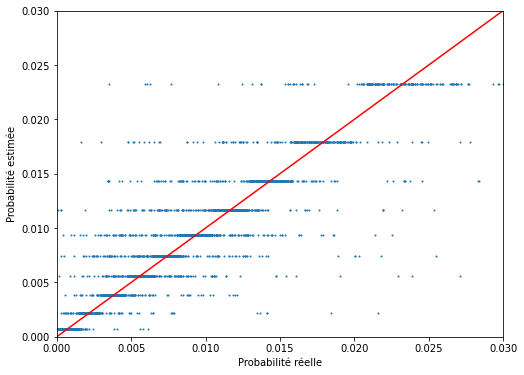

In [368]:
plt.figure(figsize=(8,6))
premiere_bissectrice = np.linspace(0,k * 1e-1,100)
plt.plot(premiere_bissectrice,premiere_bissectrice, color='red')
plt.scatter(y_test, np.vectorize(retour_proba.get_proba)(rf2_clf.predict(X_test)),s=1)
plt.xlabel("Probabilité réelle")
plt.ylabel("Probabilité estimée")
plt.xlim(0,0.03)
plt.ylim(0,0.03)
#plt.savefig("bissectrice_12_classes.png")

In [45]:
# BEL AFFICHAGE
def ecart_relatif(pred,theo) : 
    return np.abs(theo - pred) / theo

def BELLE_PIPELINE(nb_class):

    discretizer = Discretizer(y_train_exp, nb_class=nb_class)
    y_train_class = discretizer.discretize(y_train_exp)
    y_test_class  = discretizer.discretize(y_test_exp)
    
    retour_proba = classe_vers_probas(discretizer,nb_class=nb_class)
    retour_proba.set_lambda(lam=lam)
    
    rf2_clf = RandomForestClassifier(n_estimators=100,
                                     criterion='gini', #{“gini”, “entropy”}
                                     max_depth=100,#10,#0, #default=None
                                     min_samples_split=3, #int or float, default=2
                                     random_state=42,
                                     max_features='auto',
                                     bootstrap=True,
                                     min_samples_leaf=1
                                    )

    rf2_clf.fit(X_train, np.ravel(y_train_class))
    
    return rf2_clf, retour_proba





TypeError: __init__() missing 1 required positional argument: 'nb_class'

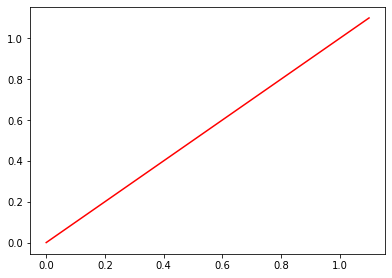

In [404]:
fig = plt.figure(figsize=(14,10))

n_classes = [10,100,300,400]
premiere_bissectrice = np.linspace(0,k * 1e-1,100)

for (plot_idx, n_class) in enumerate(n_classes):


    ax = fig.add_subplot(2, 2, (plot_idx+1))
    

    
    ax.plot(premiere_bissectrice,premiere_bissectrice, color='red')
    
    
    rf2_clf = BELLE_PIPE(n_class)
    
    ax.scatter(y_test, np.vectorize(retour_proba.get_proba)(rf2_clf.predict(X_test)),s=1)
    ax.set_title("k = {}".format(n_class))
    plt.xlabel("Probabilité réelle")
    plt.ylabel("Probabilité estimée")
    plt.xlim(0,0.03)
    plt.ylim(0,0.03)

   

#fig.tight_layout(pad=0.1)

In [449]:
ecarts = list()
Ns = [i for i in range(360,372,1)]
for n in Ns:
    rf2_clf, retour_proba = BELLE_PIPELINE(n)
    pred = np.vectorize(retour_proba.get_proba)(rf2_clf.predict(X_test))
    
    ecarts.append(np.mean(ecart_relatif(pred=pred,theo=y_test)))
    

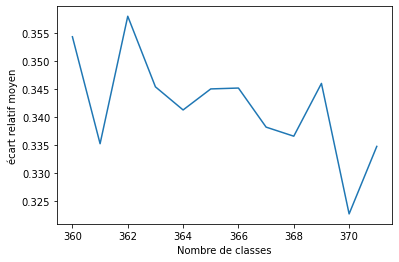

In [450]:

    

plt.plot(Ns,ecarts)
plt.xlabel("Nombre de classes")
plt.ylabel("écart relatif moyen")
#plt.savefig("ecart_n_classe.png")
plt.show()


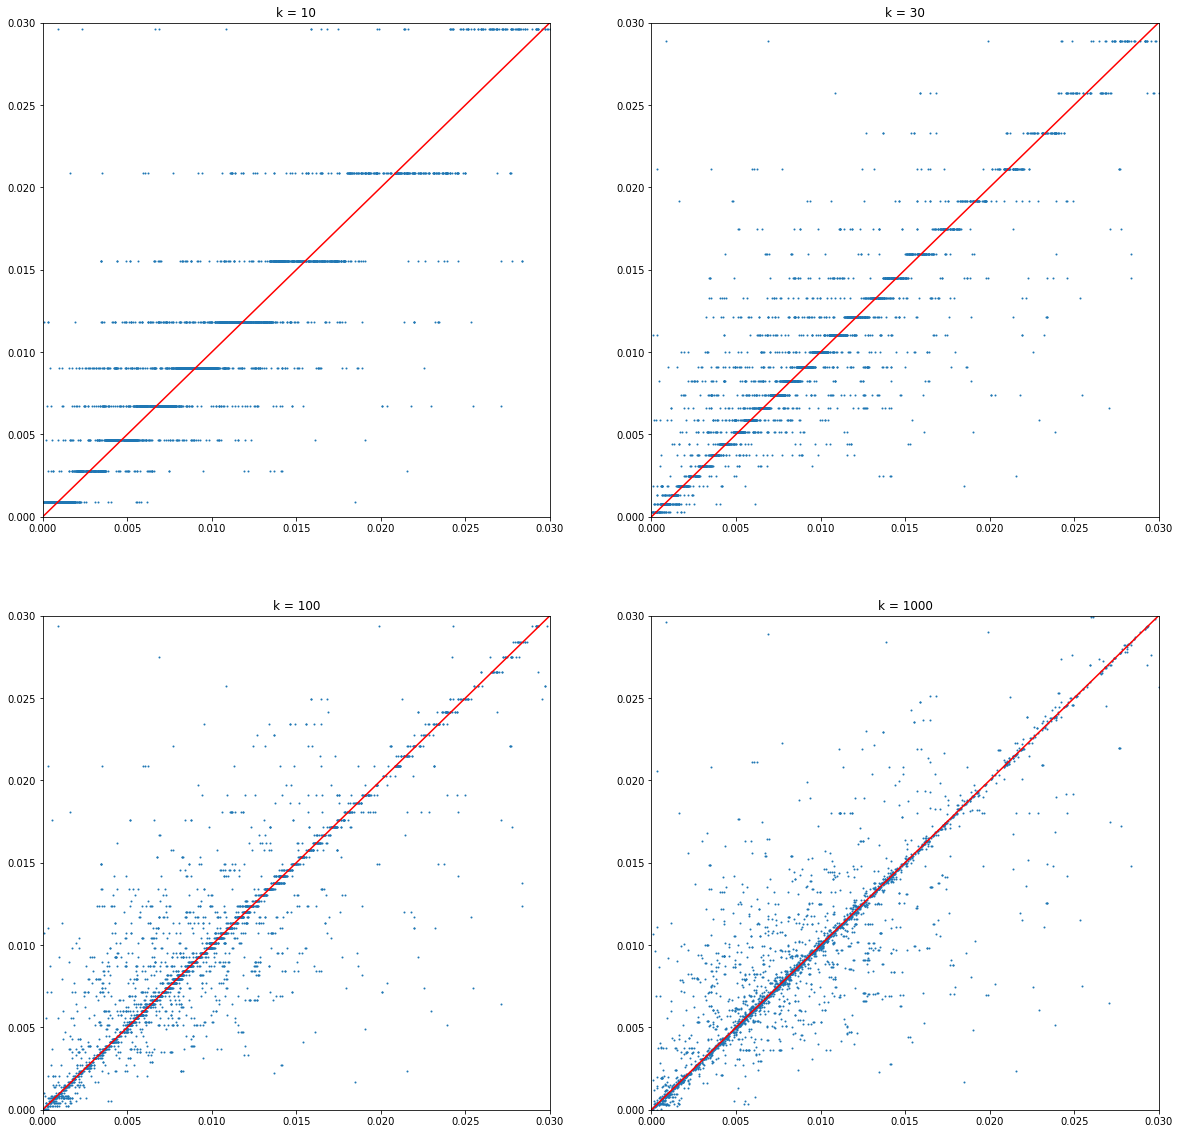

In [423]:
figure, axis = plt.subplots(2, 2, figsize=(20,20))

n = 10
rf2_clf, retour_proba = BELLE_PIPELINE(n)
    
axis[0, 0].set_xlim(0,0.03)
axis[0, 0].set_ylim(0,0.03)
pred = np.vectorize(retour_proba.get_proba)(rf2_clf.predict(X_test))
axis[0, 0].scatter(y_test, pred,s=1)
axis[0, 0].set_title("k = {}".format(n))
axis[0, 0].plot(premiere_bissectrice,premiere_bissectrice, color='red')
axis[0, 0].set_title("k = 10")
  
    
    
    
n = 30
rf2_clf, retour_proba = BELLE_PIPELINE(n)
axis[0, 1].set_xlim(0,0.03)
axis[0, 1].set_ylim(0,0.03)
pred = np.vectorize(retour_proba.get_proba)(rf2_clf.predict(X_test))
axis[0, 1].scatter(y_test, pred,s=1)
axis[0, 1].set_title("k = {}".format(n))
axis[0, 1].plot(premiere_bissectrice,premiere_bissectrice, color='red')
 


n = 100
rf2_clf, retour_proba = BELLE_PIPELINE(n)
axis[1, 0].set_xlim(0,0.03)
axis[1, 0].set_ylim(0,0.03)
pred = np.vectorize(retour_proba.get_proba)(rf2_clf.predict(X_test))
axis[1, 0].scatter(y_test, pred,s=1)
axis[1, 0].set_title("k = {}".format(n))
axis[1, 0].plot(premiere_bissectrice,premiere_bissectrice, color='red')
 


    
n = 1000
rf2_clf, retour_proba = BELLE_PIPELINE(n)
axis[1, 1].set_xlim(0,0.03)
axis[1, 1].set_ylim(0,0.03)
pred = np.vectorize(retour_proba.get_proba)(rf2_clf.predict(X_test))
axis[1, 1].scatter(y_test,pred,s=1)
axis[1, 1].set_title("k = {}".format(n))
axis[1, 1].plot(premiere_bissectrice,premiere_bissectrice, color='red')


plt.savefig('10_30_100_1000.png')
plt.show()

In [48]:
n = 370
rf2_clf, retour_proba = BELLE_PIPELINE(n)


In [49]:
rf2_clf.score(X_test, np.ravel(y_test_class))

0.001938521185267239

0.3226527113169282


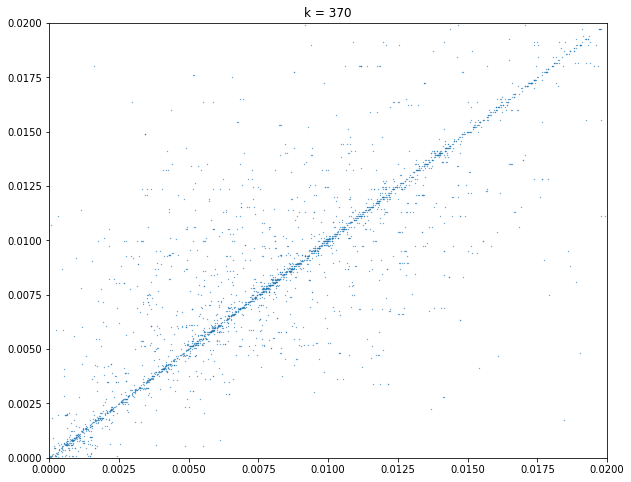

In [453]:
plt.figure(figsize=(10,8))
plt.xlim(0,0.02)
plt.ylim(0,0.02)
pred = np.vectorize(retour_proba.get_proba)(rf2_clf.predict(X_test))
plt.scatter(y_test,pred,s=0.08)
plt.title("k = {}".format(n))
#plt.plot(premiere_bissectrice,premiere_bissectrice, color='red')

plt.savefig('n370.png')

print(np.mean(ecart_relatif(pred,y_test)))